# Libraries

Load required libraries

In [101]:
import numpy as np
import pandas as pd
import io
#import requests
import matplotlib.pyplot as plt
import warnings
from IPython.display import Markdown as md
import seaborn as sb
#import missingno as msno


warnings.filterwarnings('ignore')
# set to show all columns
pd.set_option('display.max_columns', 55)

# Declarations

Created function moving average columns and plot graphs (helps to reuse the coide)

In [102]:
def plot_var(var='positive'):
    """
    Plots a bar chart of the given variable over the date range
    """
    assert type(var)==str, "Expected string as the variable name"

    y = df2[var]
    x = df2['date']
    plt.figure(figsize=(20,4))
    plt.title("Plot of \"{}\" for New York".format(var),fontsize=18)
    plt.plot(x,y,color='navy')
    plt.grid(False)
    plt.xticks(fontsize=14,rotation=45)
    plt.yticks(fontsize=14)
    plt.show()

def plot_hist(var='positiveIncrease'):
    """
    Plots a bar chart of the given variable over the date range
    """
    assert type(var)==str, "Expected string as the variable name"

    y = df2[var]
    plt.figure(figsize=(20,4))
    plt.title("Plot of \"{}\" for New York".format(var),fontsize=18)
    plt.hist(y,color='royalblue')
    plt.grid(False)
    plt.xticks(fontsize=14,rotation=45)
    plt.yticks(fontsize=14)
    plt.show()

def add_sevenday_newCases(df):

    df['sevenDayAvg_newCases'] = 'NA'

    for i in range(0, len(df['positiveIncrease'])):
        if i < 7:
            df['sevenDayAvg_newCases'][i] = 0
        else :
            weekly = []
            for y in range(0,7):
                weekly.append(df['positiveIncrease'][i-y])
            df['sevenDayAvg_newCases'][i] = round(sum(weekly) / 7)
    return df

# 7 days moving average for hospitalization
def add_sevenday_hospitalize(df):

    df['sevenDayAvg_hospitalize'] = 'NA'

    for i in range(0, len(df['hospitalizedIncrease'])):
        if i < 7:
            df['sevenDayAvg_hospitalize'][i] = 0
        else :
            weekly = []
            for y in range(0,7):
                weekly.append(df['hospitalizedIncrease'][i-y])
            df['sevenDayAvg_hospitalize'][i] = round(sum(weekly) / 7)
    return df

# 7 days moving average for Death
def add_sevenday_death(df):

    df['sevenDayAvg_death'] = 'NA'

    for i in range(0, len(df['deathIncrease'])):
        if i < 7:
            df['sevenDayAvg_death'][i] = 0
        else :
            weekly = []
            for y in range(0,7):
                weekly.append(df['deathIncrease'][i-y])
            df['sevenDayAvg_death'][i] = round(sum(weekly) / 7)
    return df

# 7 days moving average for Test Result
def add_sevenday_testResult(df):

    df['sevenDayAvg_testResult'] = 'NA'

    for i in range(0, len(df['totalTestResultsIncrease'])):
        if i < 7:
            df['sevenDayAvg_testResult'][i] = 0
        else :
            weekly = []
            for y in range(0,7):
                weekly.append(df['totalTestResultsIncrease'][i-y])
            df['sevenDayAvg_testResult'][i] = round(sum(weekly) / 7)
    return df

# Rejected Data Sources

## Rejected Datasource 1 (CDC)

In [103]:
%%script echo skipping # to make code not execute

from requests import request
import json
from pandas.io.json import json_normalize
import pandas as pd
import datetime


response=request(url='https://data.cdc.gov/id/vbim-akqf.json?current_status=Laboratory-confirmed%20case', method='get')
covid_records_cdc = response.json()
cdc_df = pd.DataFrame(covid_records_cdc)
format_dt = '%Y-%m-%dT%H:%M:%S.%f'
format_dt2 = '%Y-%m-%d'
# Format dates
pd.to_datetime(cdc_df['cdc_case_earliest_dt'], format=format_dt)
pd.to_datetime(cdc_df['cdc_report_dt'], format=format_dt)
pd.to_datetime(cdc_df['pos_spec_dt'], format=format_dt)
cdc_df['cdc_case_earliest_dt']=pd.to_datetime(cdc_df['cdc_case_earliest_dt'], format=format_dt2)
cdc_df['cdc_report_dt']=pd.to_datetime(cdc_df['cdc_report_dt'], format=format_dt2)
cdc_df['pos_spec_dt']=pd.to_datetime(cdc_df['pos_spec_dt'], format=format_dt2)
cdc_df.head()


Couldn't find program: 'echo'


*Since the data source doesn't provide the location of the patient, we won't be able to use it for our current
analysis*

## Rejected Datasource 2 (Johns Hopkins University)


In [104]:
%%script echo skipping # to make code not execute

# There are 424 columns present in the dataset, and the dates are present as columns. We can apply pivot on dates and
# convert columns to rows. We will delete unnecessary columns such as iso2,iso3, Country_Region, Lat, Long_, FIPS,
# Admin2, Combined_Key. Apply filter on Province_State i.e New York and timeline from March 2020 to June 2020.

# Get data
df_jhu = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_"
                     + "covid_19_time_series/time_series_covid19_confirmed_US.csv")
# View data
df_jhu.head()

df_jhu_clean = pd.DataFrame(df_jhu)
# Filter by New york state
df_jhu_clean = df_jhu_clean[df_jhu_clean['Province_State'] == 'New York']
# Timeline from March to June
df_jhu_clean = df_jhu_clean.loc[:, '3/1/20':'6/30/20']
# Check for Null value
df_jhu_clean.isnull().values.any()
# View Data
df_jhu_clean.head()

# Apply reset index and calculate new cases from confirmed cases field.

# List for Columns
column_list = df_jhu_clean.columns.tolist()
# Convert columns to rows
df_jhu_2 = pd.melt(df_jhu_clean, value_vars= column_list, value_name="Confirmed_Cases")
# Change column name to Date
df_jhu_2.rename(columns = {'variable':'Dates'}, inplace = True)
# Sum confirm cased and group by date
df_jhu_2 = pd.DataFrame(df2.groupby('Dates').sum())
# reset index
df_jhu_2.reset_index(level=None, inplace=True)
# Format Dates column
df_jhu_2['Dates'] =  pd.to_datetime(df2['Dates'], format='%m/%d/%y')
# Order by Dates
df_jhu_2.sort_values(by=['Dates'], inplace=True, ascending=True)
# View data
print(df_jhu_2.head())

# Reset Index
df_jhu_2.reset_index(level=None, drop=True, inplace=True)

# Calculate New Cases per day
def New_Cases(ds):
    df2['New_Cases'] = 'NA'

    for i in range(0, len(ds["Confirmed_Cases"])):
        if i == 0:
            ds['New_Cases'][i] = 0
        elif i > 0:
            ds['New_Cases'][i]= ds['Confirmed_Cases'][i] - ds['Confirmed_Cases'][i-1]
    return ds

# Call Function
New_Cases(df_jhu_2)

# Graph for Daily New cases
def line_graph():
    x = df_jhu_2['Dates']
    y = df_jhu_2['New_Cases']
    plt.figure(figsize=(20,4))
    plt.title("Plot of \"{}\" for New York".format("New Cases"),fontsize=18)
    plt.plot(x,y,color='navy')
    plt.grid(False)
    plt.xticks(fontsize=14,rotation=45)
    plt.yticks(fontsize=14)
    plt.show()

line_graph()

Couldn't find program: 'echo'


Since the dataset required data manipulation they are <li> Convert columns to rows <li> Calculate the confirmed cases using group by on Date column. <li> Calculate Daily new cases using the Confirmed case. <li> Confirmed cases, Death, and Recovered cases are not present in one file, from different csv file need to merge these columns 

*Opted for cleaner data set at COVID Tracking Project at Atlanta.*

# Import Data

Import data from API call and apply try catch block to handle error

In [105]:
# API Hosting Suppose to End 5/1/2021
url="https://api.covidtracking.com/v1/states/ny/daily.cs" # API Call for NY data

try:
    s = requests.get(url).content
    df = pd.read_csv(io.StringIO(s.decode('utf-8')))

    if df.values.size < 3:  # ensure DF has values (may just contain 2 error values)
        raise FileNotFoundError("No data in API")
    else:
        df.to_csv('ny_covid_data.csv', index=False)  # future proof in case api goes down
        df = pd.read_csv(io.StringIO(s.decode('utf-8')))

except FileNotFoundError as fnf_error:
    df = pd.read_csv("ny_covid_data.csv")  # read from most recently fetched data
except: # catch any other unexpected error
    df = pd.read_csv("ny_covid_data.csv")

# Data Transformation

Change the date fromat of date column,  convert '20210306' to '2020-03-06' and apply filter on date where date less than or equal to 2020-06-30.

In [106]:
# Format dates
df['date'] =  pd.to_datetime(df['date'], format='%Y%m%d') 

# Impute NaN values
# df.fillna(value=-1, inplace=True)

# apply filter on date
df = df[df['date'] <= '2020-06-30']


# NYC Holiday calendar dataset for 2020


In [107]:
# 3/20/21 A.C. commented below, we don't need Holiday and date feature

# holiday_data = {'date': ['2020-01-01','2020-01-20','2020-02-17','2020-05-25','2020-06-30','2020-09-07','2020-10-12',
# '2020-11-03','2020-11-11','2020-11-26','2020-12-25'],
# 		'Holiday': ['New Year Day','Martin Luther King Jr. Day', 'Presidents Day', 'Memorial Day',
# 		'Independence Day(Observed)','Labor Day','Columbus Day','Election Day','Veterans Day','Thanksgiving day',
# 		'Christmas Day' ],
#         'is_holiday':['1','1','1','1','1','1','1','1','1','1','1'],
# 		'is_long_weekend':['0','1','1','1','1','1','1','0','0','1','1']
# 		}

# calendar_df = pd.DataFrame (holiday_data, columns = ['date','Holiday','is_holiday','is_long_weekend'])

holiday_data = {'date': ['2020-01-01','2020-01-20','2020-02-17','2020-05-25','2020-06-30','2020-09-07','2020-10-12',
                         '2020-11-03','2020-11-11','2020-11-26','2020-12-25'],
        'is_holiday':['1','1','1','1','1','1','1','1','1','1','1'],
		'is_long_weekend':['0','1','1','1','1','1','1','0','0','1','1']
                }

calendar_df = pd.DataFrame (holiday_data, columns = ['date', 'is_holiday','is_long_weekend'])

calendar_df['date'] =  pd.to_datetime(calendar_df['date'], format='%Y-%m-%d')  
df2 = df.set_index('date').join(calendar_df.set_index('date'))

# Fill remaining values with 0s for Non-Holiday times
df2['is_holiday'].fillna('0',inplace=True)
df2['is_long_weekend'].fillna('0', inplace=True) 

df2.head()

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,hospitalizedDischarged,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,...,positiveTestsAntibody,negativeTestsAntibody,totalTestsPeopleAntibody,positiveTestsPeopleAntibody,negativeTestsPeopleAntibody,totalTestsPeopleAntigen,positiveTestsPeopleAntigen,totalTestsAntigen,positiveTestsAntigen,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,dataQualityGrade,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade,is_holiday,is_long_weekend
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-30,NY,393454,NaN,NaN,NaN,totalTestEncountersViral,3914938,891.0,89995.0,217.0,NaN,137.0,NaN,NaN,6/29/2020 00:00,2020-06-29T00:00:00Z,06/28 20:00,24855.0,89995.0,70487.0,2020-06-29T00:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,524,0,393454,52025,393454,NaN,13,0,e526c4b8fb8a28dea6f1fd081b5bebb486a84195,0,0,0,0,0,NaN,1,1
2020-06-29,NY,392930,NaN,NaN,NaN,totalTestEncountersViral,3862913,853.0,89995.0,216.0,NaN,136.0,NaN,NaN,6/28/2020 23:59,2020-06-28T23:59:00Z,06/28 19:59,24842.0,89995.0,70435.0,2020-06-28T23:59:00Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,391,0,392930,46428,392930,NaN,7,0,51bb925b19c9907d34d959bc544eb501ad200318,0,0,0,0,0,NaN,0,0
2020-06-28,NY,392539,NaN,NaN,NaN,totalTestEncountersViral,3816485,869.0,89995.0,229.0,NaN,167.0,NaN,NaN,6/27/2020 23:59,2020-06-27T23:59:00Z,06/27 19:59,24835.0,89995.0,70010.0,2020-06-27T23:59:00Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,616,0,392539,61906,392539,NaN,5,0,c6b2f6c762a5771b69bd2b3a1799ddd8dc4733e2,0,0,0,0,0,NaN,0,0
2020-06-27,NY,391923,NaN,NaN,NaN,totalTestEncountersViral,3754579,908.0,89995.0,230.0,NaN,167.0,NaN,NaN,6/26/2020 23:59,2020-06-26T23:59:00Z,06/26 19:59,24830.0,89995.0,70010.0,2020-06-26T23:59:00Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,703,0,391923,73262,391923,NaN,16,0,49d082c4525827acb47baf3905154b915f46e62d,0,0,0,0,0,NaN,0,0
2020-06-26,NY,391220,NaN,NaN,NaN,totalTestEncountersViral,3681317,951.0,89995.0,244.0,NaN,167.0,NaN,NaN,6/25/2020 23:59,2020-06-25T23:59:00Z,06/25 19:59,24814.0,89995.0,70010.0,2020-06-25T23:59:00Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,805,0,391220,61723,391220,NaN,14,0,0415ca28a21a379fdec8a1a34f7bf57b53a7b511,0,0,0,0,0,NaN,0,0


## MTA Ridership Data for 2020

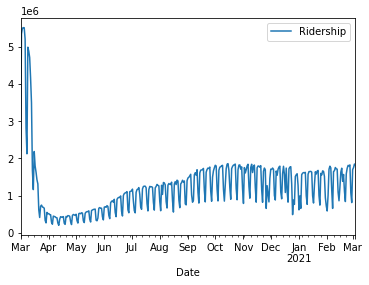

In [108]:
mta_df = pd.read_csv('MTA_data.csv',index_col=[0], parse_dates=[0])

mta_df = mta_df[[ 'Subways: Total Estimated Ridership']] 
 
mta_df['Subways: Total Estimated Ridership'] = pd.to_numeric(mta_df['Subways: Total Estimated Ridership'])

mta_df.columns = ['Ridership']
mta_df.plot()

# A.C. edit 3/20/2021, must set to variable, function alone doesn't update reference
df2 = df2.join(mta_df)

# EDA

## Missing Data

There are columns that don't have a significant impact to our analysis, namely date checked and date modified features.

These columns we want to exclude.

In [109]:
df2.drop(['dateChecked', 'dateModified'],axis=1,inplace=True)

We set a threshold of to tolerate up to 90% of values being NA per column. If a column contains more than 90% of NA
values we drop it.

In [110]:
df2.info
limitPer = len(df2) * .99

df2 = df2.dropna(thresh=limitPer, axis=1)


There are also many features that just have zeros in them, we want to exclude that in our set as well.

In [111]:
df2 = df2.loc[:, (df2 != 0).any(axis=0)]

We ended up excluding 20 columns that just contained NA values, 2 columns that didn't have significant information
(date modified and date checked), and 6 columns that only contained zeros.

In [112]:
# set date index in asending order
df2.sort_values(by=['date'], inplace=True, ascending=True)


# add sevendays column to dataset
add_sevenday_newCases(df2)
add_sevenday_hospitalize(df2)
add_sevenday_death(df2)
add_sevenday_testResult(df2)

# change type of column object to numeric
df2[['sevenDayAvg_newCases', 'sevenDayAvg_hospitalize', 'sevenDayAvg_death',  
    'sevenDayAvg_testResult']] = df2[['sevenDayAvg_newCases', 
                                     'sevenDayAvg_hospitalize', 'sevenDayAvg_death',  
                                     'sevenDayAvg_testResult']].apply(pd.to_numeric)


Set Date index in asdending order then added 4 new columns in to the datset, they are sevenDayAvg_newCases, sevenDayAvg_hospitalize, sevenDayAvg_death, sevenDayAvg_testResult. Change the datatype of newly added columns from object to numeric.

# Backup Final Dataset

Exported a csv file named final-ny-data.csv and stored in Git repo. 

In [113]:

df2['date']=df2.index

df2 = df2.reset_index(drop=True)

#df2.to_csv('final-ny-data.csv', index=False)

## Feature Plots
In this first plot we can see the daily number of positive cases in NY from March 2020 - June 30, 2020:

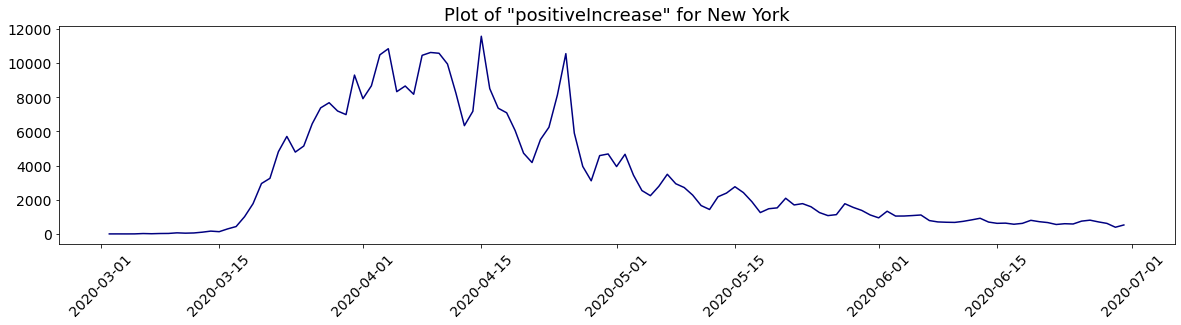

In total there were 393,454 positive cases in New York during that time range.

In [114]:
plot_var('positiveIncrease')

totalCases = "{:,.0f}".format(df2['positiveIncrease'].sum())

md(f"In total there were {totalCases} positive cases in New York during that time range.")

The following plots also show the increases in hospitalizations, deaths, and the total amount of test results.

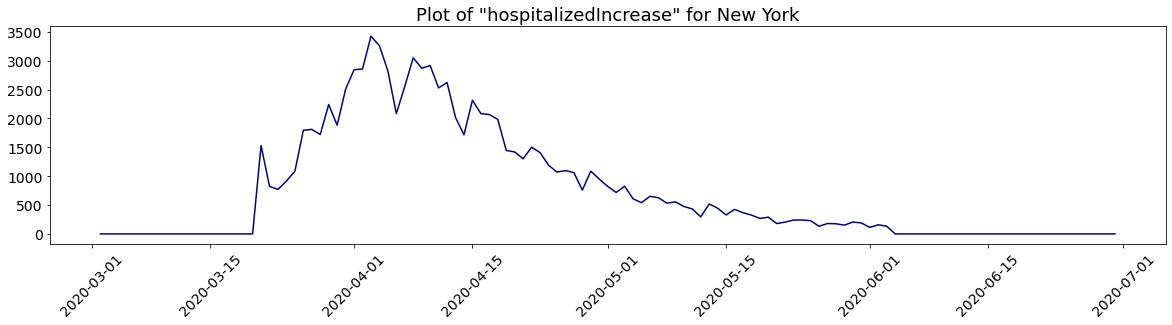

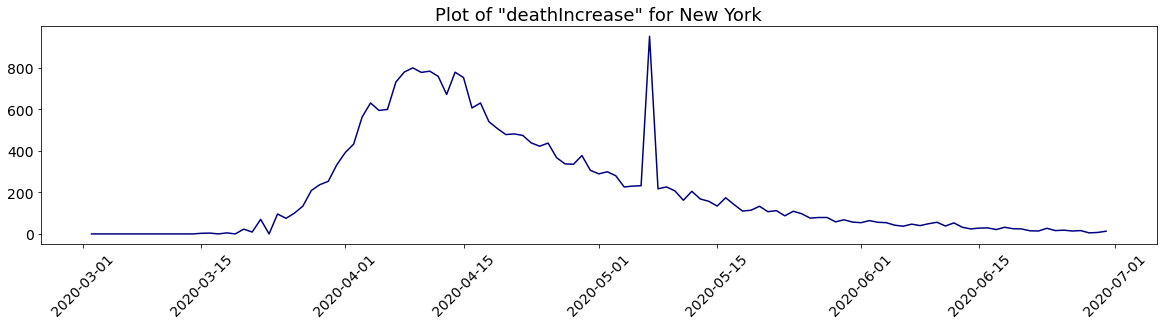

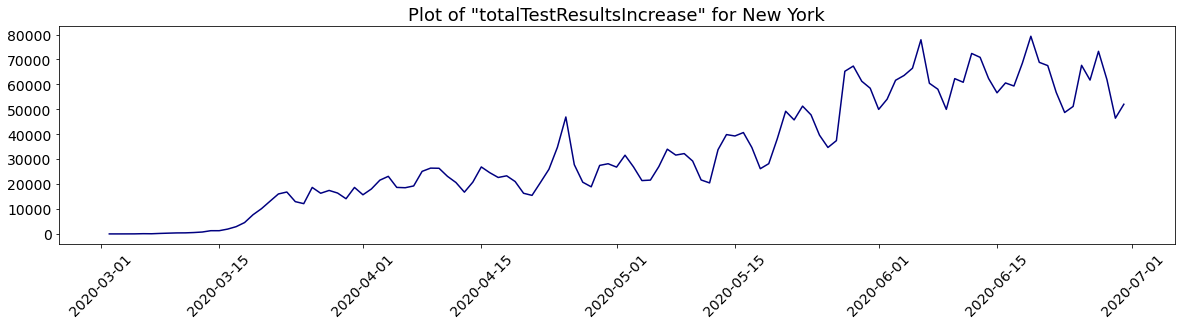

In [115]:
plot_var('hospitalizedIncrease')

plot_var('deathIncrease')

plot_var('totalTestResultsIncrease')

pd.set_option('display.max_columns', 56)

# 7 days moving average for positiveIncrease
df2.sort_values(by=['date'], inplace=True, ascending=True)

# reset index
# A.C. edit 3/20/2021 commented below, reset not needed
# df2.reset_index(level=0, inplace=True)

## Plots on 7-Day Moving Averages

Below plots shows the 7-day moving averages of new cases, hospitalization, death and test result.

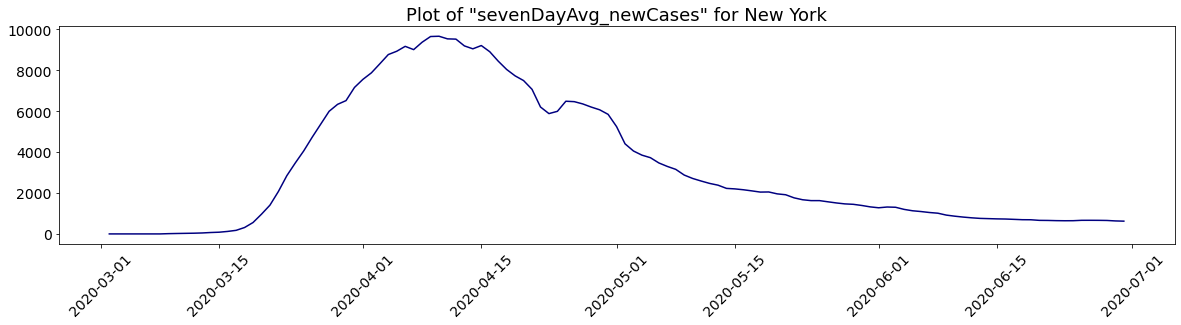

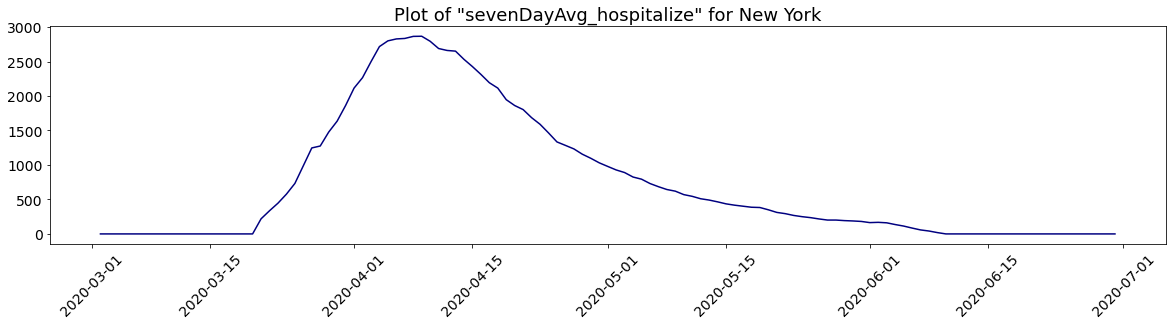

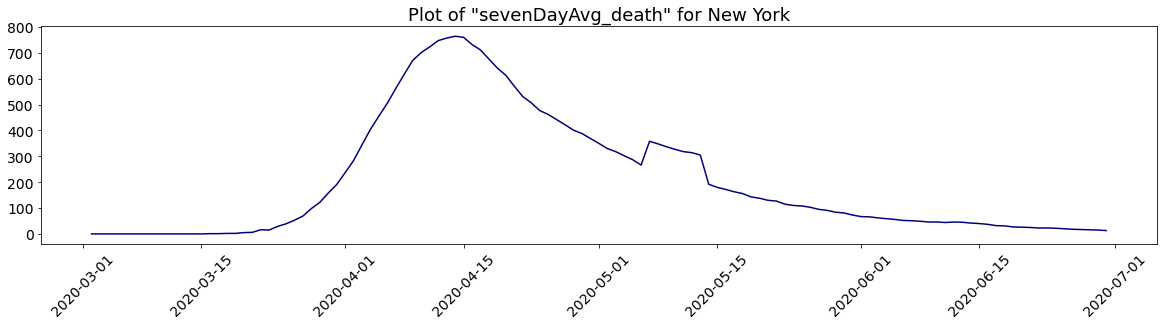

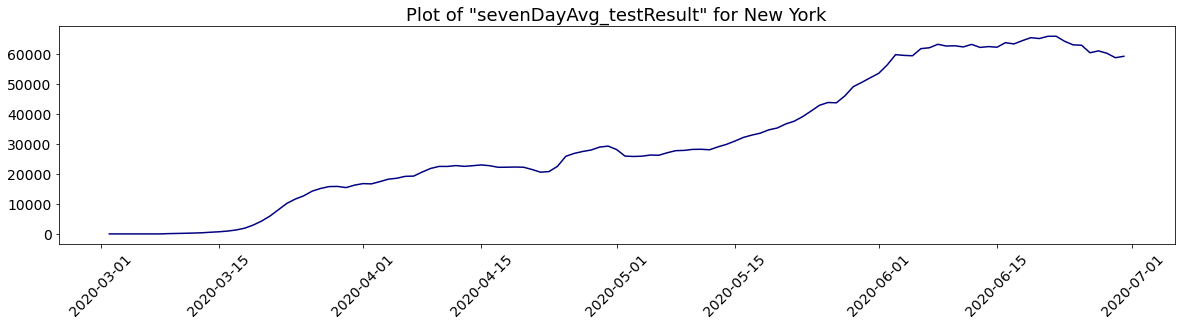

In [116]:
plot_var('sevenDayAvg_newCases')
plot_var('sevenDayAvg_hospitalize')
plot_var('sevenDayAvg_death')
plot_var('sevenDayAvg_testResult')

## Histogram Plots

Histogram shows the distribution of new cases,  hospitalization, death and test result along with 7-days moving average measures.

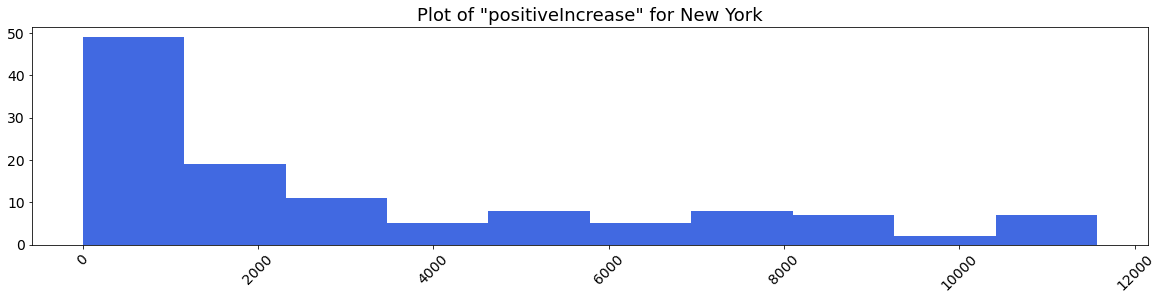

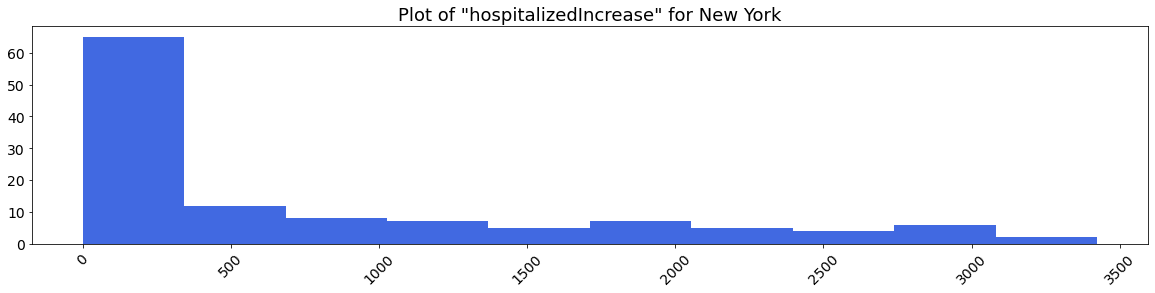

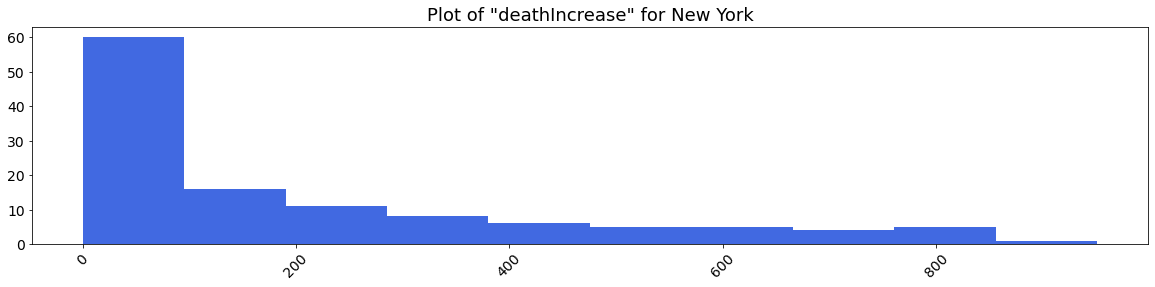

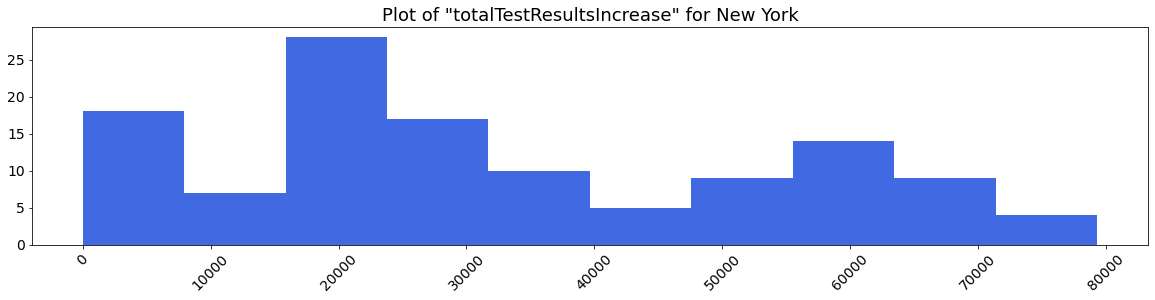

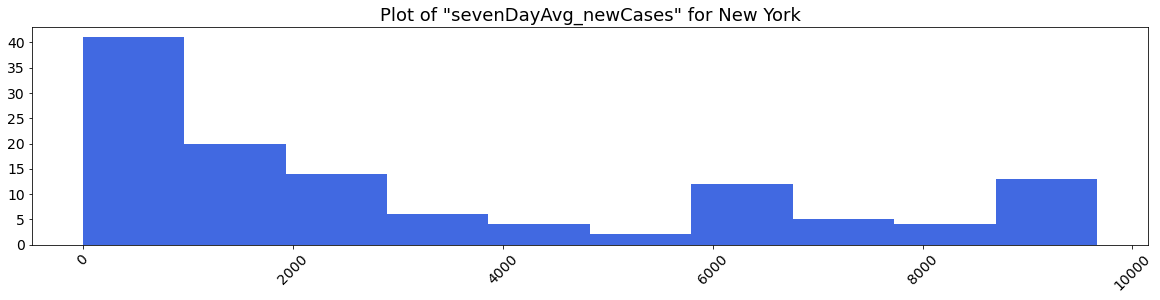

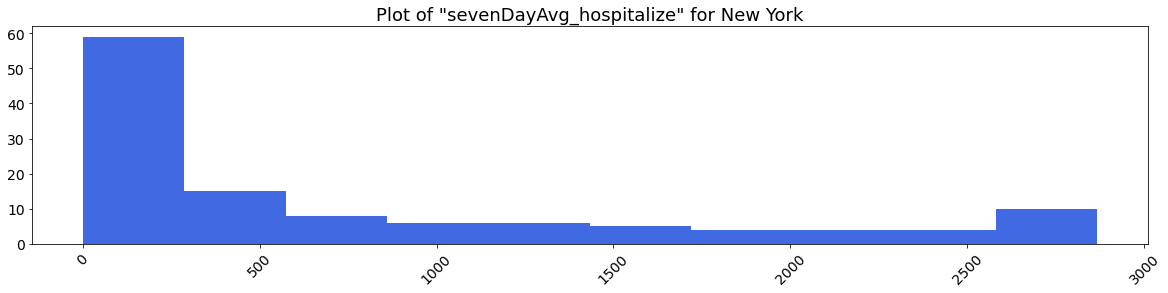

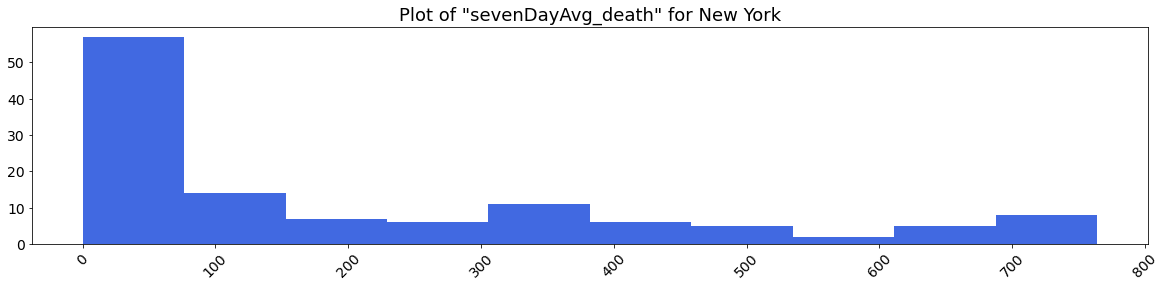

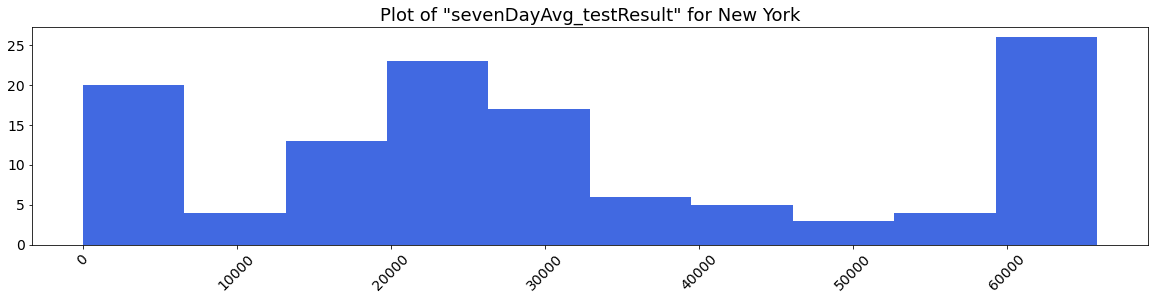

In [117]:
plot_hist('positiveIncrease')

plot_hist('hospitalizedIncrease')

plot_hist('deathIncrease')

plot_hist('totalTestResultsIncrease')

plot_hist('sevenDayAvg_newCases')

plot_hist('sevenDayAvg_hospitalize')

plot_hist('sevenDayAvg_death')

plot_hist('sevenDayAvg_testResult')

## Correlation Matrix

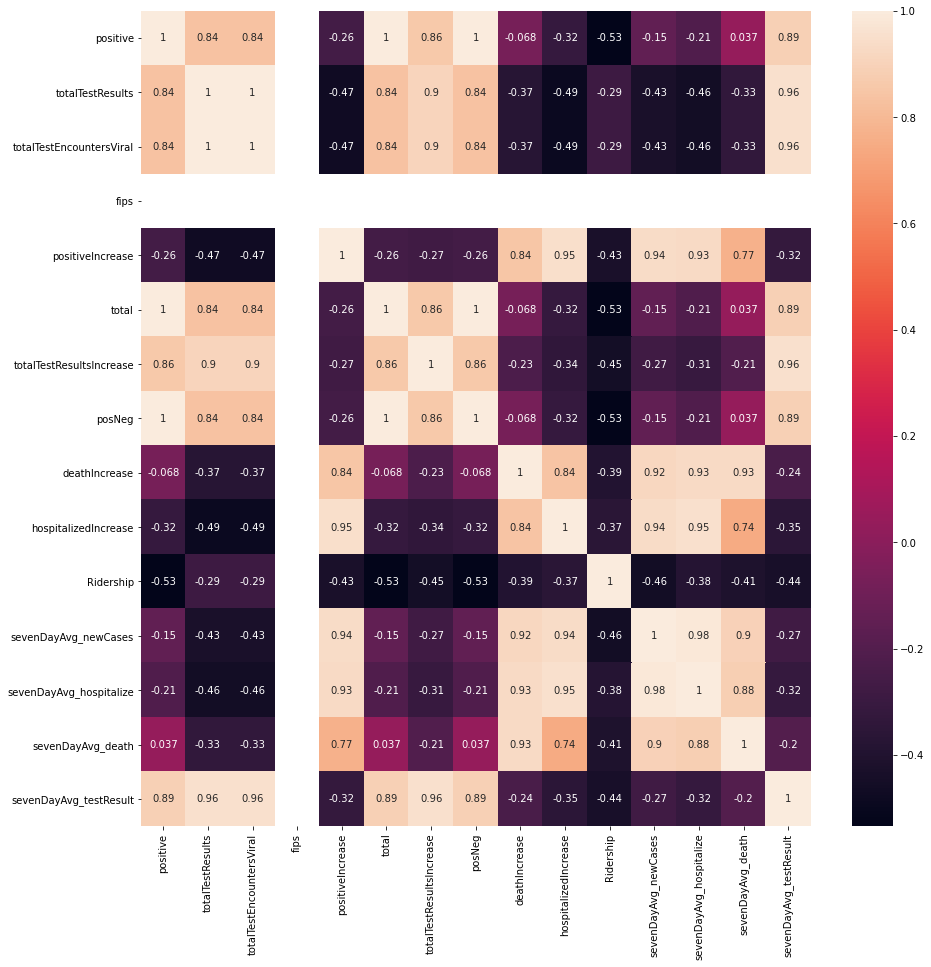

In [118]:
corrMatrix = df2.corr()
fig, ax = plt.subplots(figsize=(15,15))
sb.heatmap(corrMatrix, annot=True, ax = ax)
plt.show()

It's plain to see that death increases are positively correlated with hospitalizations and positive cases. It would also
make sense that there would exist a negative correlations between deaths and total tests done, as the more informed the
population is the better course of action they can take based on their status results.


## Scatter Matrix Plot

A scatter plot matrix is a grid (or matrix) of scatter plots used to visualize bivariate relationships between combinations of variables. The plot shows distribution and co-relation of the of sevenDayAvg_newCases, sevenDayAvg_hospitalize, sevenDayAvg_death, sevenDayAvg_testResult.

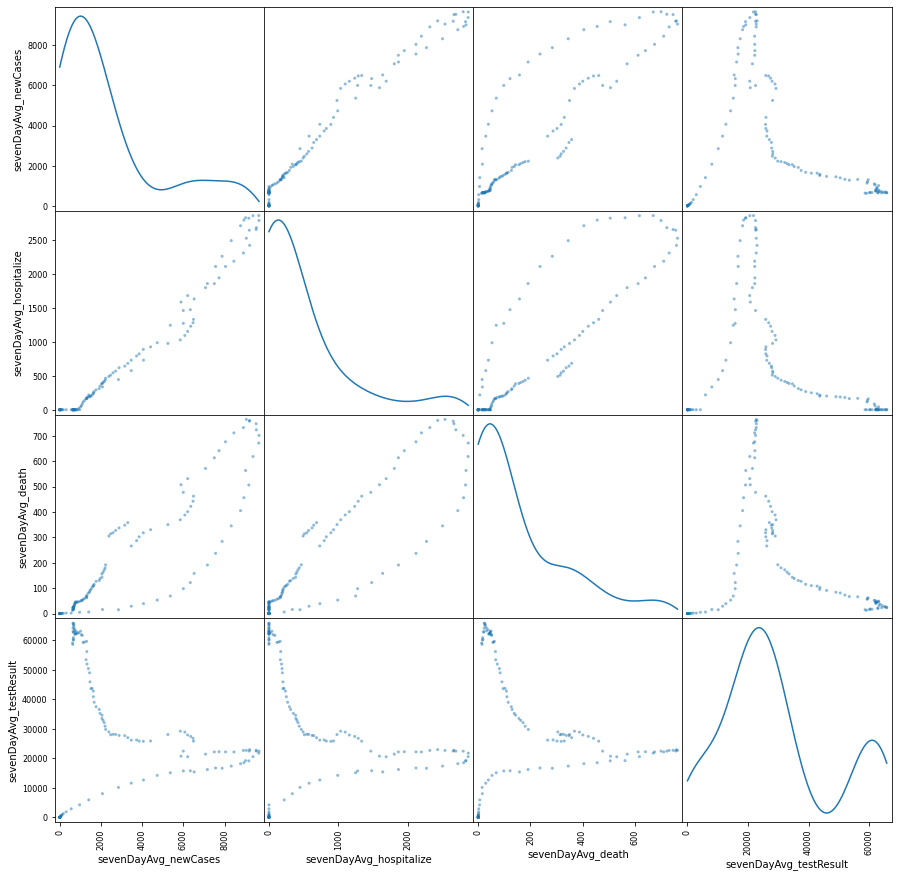

In [119]:
from pandas.plotting import scatter_matrix
df3 = df2[['sevenDayAvg_newCases', 'sevenDayAvg_hospitalize', 'sevenDayAvg_death',  'sevenDayAvg_testResult']]
scatter_matrix(df3, figsize=(15,15), diagonal = "kde")
plt.show()

Above plot shows positive co-relation between sevenDayAvg_newCases with sevenDayAvg_hospitalize 

**TO DO**
UPDATE EXPLANATION BASED ON NEW FEATURES

# Final State of data

In [120]:
df2.info

<bound method DataFrame.info of     state  positive    totalTestResultsSource  totalTestResults  \
0      NY         0  totalTestEncountersViral                 0   
1      NY         1  totalTestEncountersViral                 1   
2      NY         1  totalTestEncountersViral                10   
3      NY         3  totalTestEncountersViral                30   
4      NY        25  totalTestEncountersViral               122   
..    ...       ...                       ...               ...   
116    NY    391220  totalTestEncountersViral           3681317   
117    NY    391923  totalTestEncountersViral           3754579   
118    NY    392539  totalTestEncountersViral           3816485   
119    NY    392930  totalTestEncountersViral           3862913   
120    NY    393454  totalTestEncountersViral           3914938   

     totalTestEncountersViral  fips  positiveIncrease   total  \
0                           0    36                 0       0   
1                           1    

# Simple Exponential Smoothing

In [ ]:
Single Exponential Smoothing, SES ,  aka Simple Exponential Smoothing, is a time series forecasting method for data without a trend or seasonality.
It requires a single parameter, called alpha, also called the smoothing factor.

This parameter controls the rate at which the influence of the observations at prior time steps decay exponentially. 
Alpha is often set to a value between 0 and 1. Large values mean that the model is influenced mostly by the most recent past observations,
whereas smaller values mean more of the history is taken into account when making a prediction.

In [146]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
dates_df = df2[['date','positive']]
dates_df = dates_df.sort_values(by='date')

# Create a timeseries dataframe from the final data set that has 2 columns

dates_df['date'] = pd.to_datetime(dates_df['date'])
dates_df.set_index('date', inplace=True)

dates_df

,positive
date,
2020-03-02,0
2020-03-03,1
2020-03-04,1
2020-03-05,3
2020-03-06,25
...,...
2020-06-26,391220
2020-06-27,391923
2020-06-28,392539


In [147]:
#Create training and test data 

train_data  = dates_df.iloc[:90]
test_date = dates_df.iloc[90:]

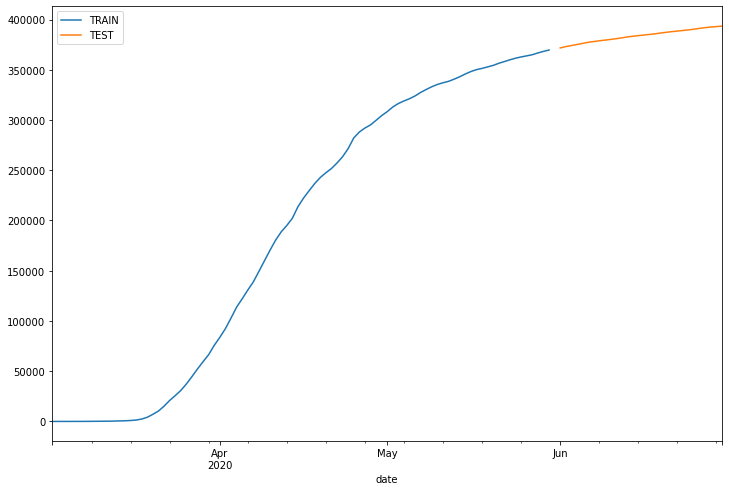

In [136]:
train_data['positive'].plot(legend=True, label='TRAIN')
test_data['positive'].plot(legend=True, label='TEST', figsize=(12,8))

In [137]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
alpha=0.2

model = SimpleExpSmoothing(train_data['positive']).fit(smoothing_level=alpha)
test_predictions_a2 = model.forecast(30)

alpha=0.6
model = SimpleExpSmoothing(train_data['positive']).fit(smoothing_level=alpha)
test_predictions_a6 = model.forecast(30)

alpha=0.8
model = SimpleExpSmoothing(train_data['positive']).fit(smoothing_level=alpha)
test_predictions_a8 = model.forecast(30)

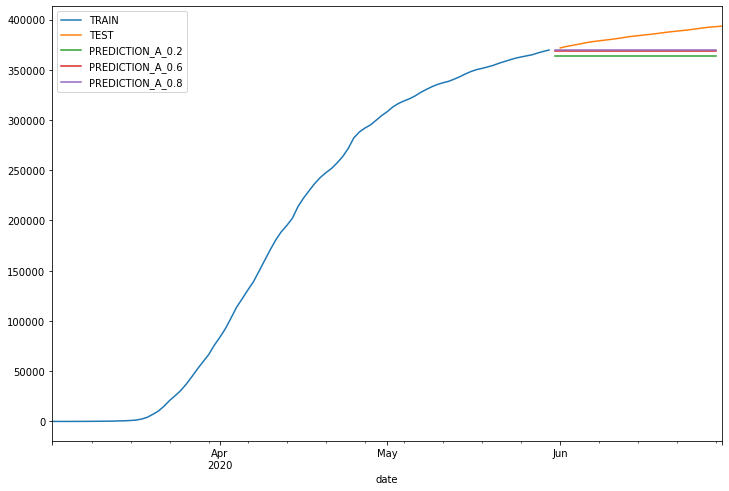

In [138]:
train_data['positive'].plot(legend=True,label='TRAIN')
test_data['positive'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions_a2.plot(legend=True,label='PREDICTION_A_0.2')
test_predictions_a6.plot(legend=True,label='PREDICTION_A_0.6')
test_predictions_a8.plot(legend=True,label='PREDICTION_A_0.8')

In [140]:
from sklearn.metrics import mean_squared_error
rms_error_a2 = np.sqrt(mean_squared_error(test_data['positive'],test_predictions_a2))
print("RMS Error with alpha 0.2 ",rms_error_a2)


rms_error_a6 = np.sqrt(mean_squared_error(test_data['positive'],test_predictions_a6))
print("RMS Error with alpha 0.6 ",rms_error_a6)


rms_error_a8 = np.sqrt(mean_squared_error(test_data['positive'],test_predictions_a8))
print("RMS Error with alpha 0.8 ",rms_error_a8)

RMS Error with alpha 0.2  21121.331885283642
RMS Error with alpha 0.6  16336.16471273935
RMS Error with alpha 0.8  15776.847433398707


Since the SimpleExponentialModel does not consider the trend and seasonality, but instead just takes the weighted average of past data and forecasts the average for all testing data. 
Hence we would notice a straight line as the prediction, instead of a curve.
Therefore, this model is not very useful in this case.

## HOLT's technique

In [145]:
from statsmodels.tsa.holtwinters import Holt

alpha=0.2

model = Holt(train_data['positive']).fit(smoothing_level=alpha)
test_predictions_a2 = model.forecast(30)

alpha=0.6
model = Holt(train_data['positive']).fit(smoothing_level=alpha)
test_predictions_a6 = model.forecast(30)


alpha=0.8
model = Holt(train_data['positive']).fit(smoothing_level=alpha)
test_predictions_a8 = model.forecast(30)


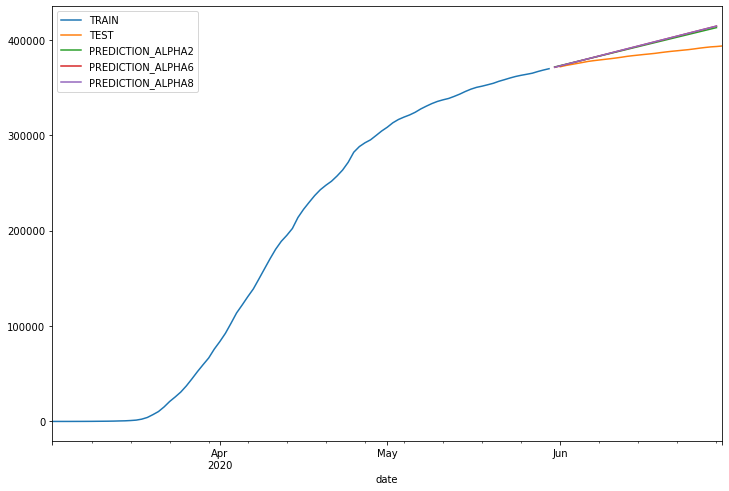

In [143]:
train_data['positive'].plot(legend=True,label='TRAIN')
test_data['positive'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions_a2.plot(legend=True,label='PREDICTION_ALPHA2')
test_predictions_a6.plot(legend=True,label='PREDICTION_ALPHA6')
test_predictions_a8.plot(legend=True,label='PREDICTION_ALPHA8')

In [144]:

rms_error_a2 = np.sqrt(mean_squared_error(test_data['positive'],test_predictions_a2))
print("RMS Error with alpha 0.2 ",rms_error_a2)


rms_error_a6 = np.sqrt(mean_squared_error(test_data['positive'],test_predictions_a6))
print("RMS Error with alpha 0.6 ",rms_error_a6)


rms_error_a8 = np.sqrt(mean_squared_error(test_data['positive'],test_predictions_a8))
print("RMS Error with alpha 0.8 ",rms_error_a8)

RMS Error with alpha 0.2  20341.74997277421
RMS Error with alpha 0.6  21128.858883917823
RMS Error with alpha 0.8  21132.934066320828


The RMSE value is quite high since we didn\'t take into account the factors that are leading to the stabiization of cases